## А/А-тестирование поиск ошибки системы сплитирования  данных у мобильного приложения. 

Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку).  
Известно, что сплит-система сломана.  
Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана.

Задача:  
Запустите A/A-тест.  
Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000).
Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.  
Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента  
Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста  

Подсказка: обратите внимание на конверсию в покупку.

## 1 Решение
импортируем необходимые библиотеки и получим данные для A/A-тест

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import random

from tqdm.auto import tqdm


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize': (16,6)})

Описание колонок:  
experimentVariant – вариант эксперимента  
version – версия приложения  
purchase – факт покупки

In [3]:
data = pd.read_csv('hw_aa.csv', sep=';')
data.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


удалим столбец с дубликатами индекса

In [4]:
data = data.drop(columns='Unnamed: 0')

Посчитаем конверсию (коэффициент покупок), группируя по варианту и версии МП. (возможно уже станет ясно где именно причины поломки)

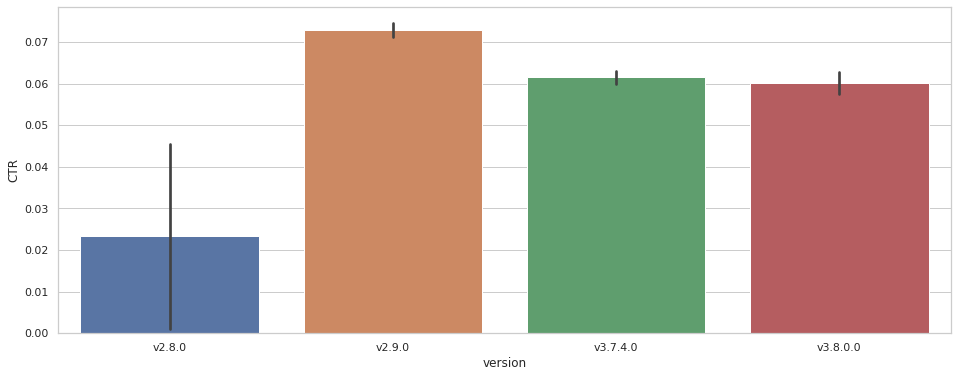

,experimentVariant,version,uid,purchase,CTR
0,0,v2.8.0,41283,41,0.000993
1,1,v2.8.0,41552,1895,0.045606
2,0,v2.9.0,11921,890,0.074658
3,1,v2.9.0,12033,858,0.071304
4,0,v3.7.4.0,4204,252,0.059943
5,1,v3.7.4.0,4221,266,0.063018
6,0,v3.8.0.0,5694,328,0.057604
7,1,v3.8.0.0,6110,384,0.062848


In [20]:
df_gr = data.groupby(['experimentVariant', 'version']).agg({'uid': 'count', 'purchase': 'sum'}) \
    .sort_values(['version', 'experimentVariant'], ascending=[True, True]).reset_index()

df_gr['CTR'] = df_gr.purchase / df_gr.uid

sns.barplot(data=df_gr, x='version', y='CTR');
plt.show()
display(df_gr)

Мы обнаружили большую разницу у v2.8.0, и подозрительно низкий CTR в контрольной группе 

Посчитаем FPR на уровне альфа = 0.05 (ставим подвыборки без возвращения объемом 1000).  
Для удобства обернём решение в функции

In [7]:
def simulation(control, test, simulations=1000, size=1000):
    # simulations количество симуляций
    # size размер подвыборки
    # симуляция A/A test
    result = []
    for i in tqdm(range(simulations)):
        s_1 = random.sample(list(control), size)
        s_2 = random.sample(list(test), size)
        # equal_var=False (поправка Уэлша, в группах могут быть разные дисперсии)
        result.append(stats.ttest_ind(s_1, s_2, equal_var=False)[1])
    return [result, simulations]

In [ ]:
def graph(result, alfa=0.05):  
    # проверка результат ложноположительных тестов не превышает alfa
    fpr = sum(np.array(result[0]) < alfa) / result[1]  
    # график
    color='cornflowerblue'
    if fpr >= alfa:
        color='tomato'       
    plt.hist(result[0], color=color, bins=50)
    plt.xlabel('pvalue')
    plt.ylabel('frequency')
    text = 'histogram of ttest A/A simulations '
    plt.title(text)
    plt.show()
    print(f'α={alfa}, FPR={fpr}')

Запустим A/A-тест для всех выборок.

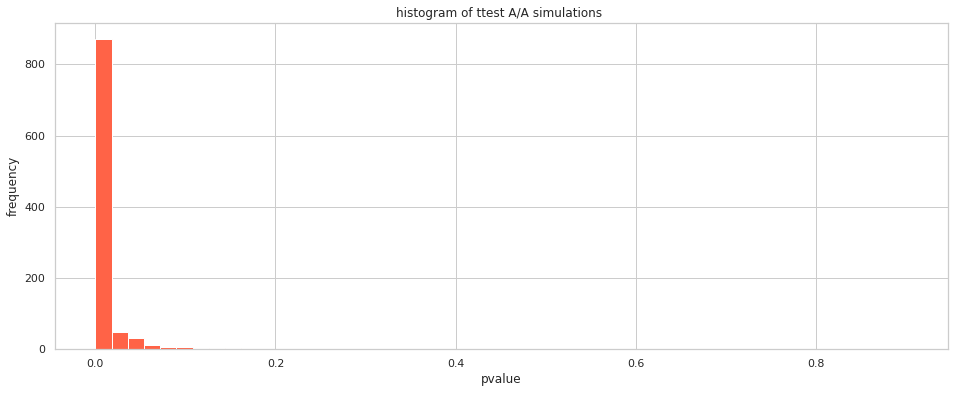

α=0.05, FPR=0.948


In [8]:
control_all = data[data.experimentVariant == 0].purchase.values
test_all = data[data.experimentVariant == 1].purchase.values

result = simulation(control_all, test_all)
graph(result)

FPR > альфа! Нам нужно наоборот – чтобы было меньше.

Мы помним об аномальном CTR выборки v2.8.0, что если мы попробуем её исключить и провести сравнение снова?

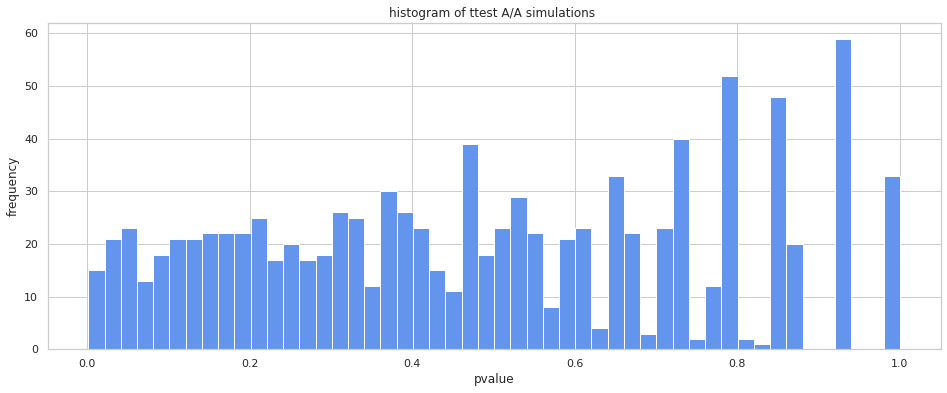

α=0.05, FPR=0.043


In [9]:
control_cut = data[(data.version != 'v2.8.0') & (data.experimentVariant == 0)].purchase.values
test_cut = data[(data.version != 'v2.8.0') & (data.experimentVariant == 1)].purchase.values
    
result = simulation(control_cut, test_cut)
graph(result)

Этот A/A-тест показал FPR в пределах нормы, становится очеведным причина некорректной работы сплит-системы - это выборка v2.8.0

## Вывод 1
1. При группировке исходных данных мы обнаружили в control выборке версии v2.8.0 аномально низкий CTR 0.000993 что вызвало подозрение к данным этой версии.
2. A/A тест control и test выборки всех версий показал уровень FPR=1.0  
3. Мы исключили версию v2.8.0 из выборки и повторили A/A тест. В этот раз FPR показал нормальный результат (FPR<α). Мы делаем вывод что поломка случилась у версии v2.8.0

## 2 Поверсионный анализ
В задании было сказано:  
- Посчитайте pvalue для каждой версии МП
- Найдите версии, где pvalue < 0.05
- Исключите версию с pvalue < 0.05 из основного датафрейма
- Повторно запустите расчет FPR через A/A. Теперь FPR < альфа Вы нашли поломку?

Чтобы быть уверенными в корректности тестов запустим A/A-тест для каждой версии

Немного дополним функцию отображения графиков, добавим подпись

In [10]:
def graph(result, title='', alfa=0.05):  
    # проверка результат ложноположительных тестов не превышает alfa
    fpr = sum(np.array(result[0]) < alfa) / result[1]  
    # график
    color='cornflowerblue'
    if fpr >= alfa:
        color='tomato'       
    plt.hist(result[0], color=color, bins=50)
    plt.xlabel('pvalue')
    plt.ylabel('frequency')
    text = 'histogram of ttest A/A simulations ' + title
    plt.title(text)
    plt.show()
    print(f'{title} α={alfa}, FPR={fpr}')

Запустим A/A-тест для каждой версии

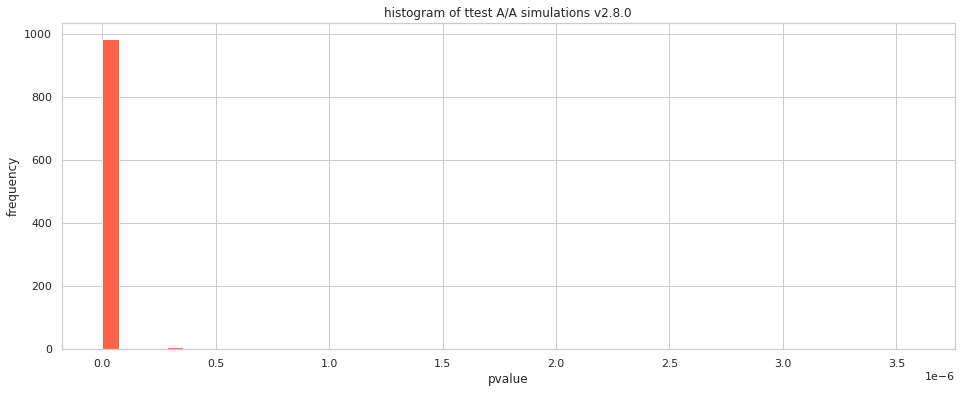

v2.8.0 α=0.05, FPR=1.0


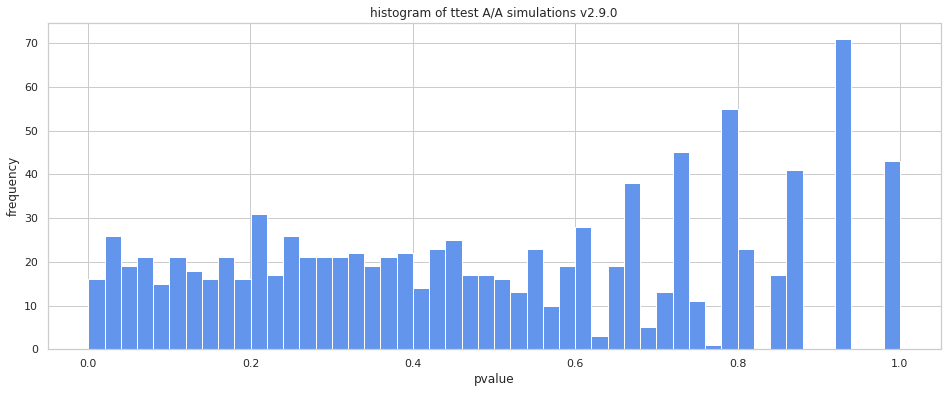

v2.9.0 α=0.05, FPR=0.049


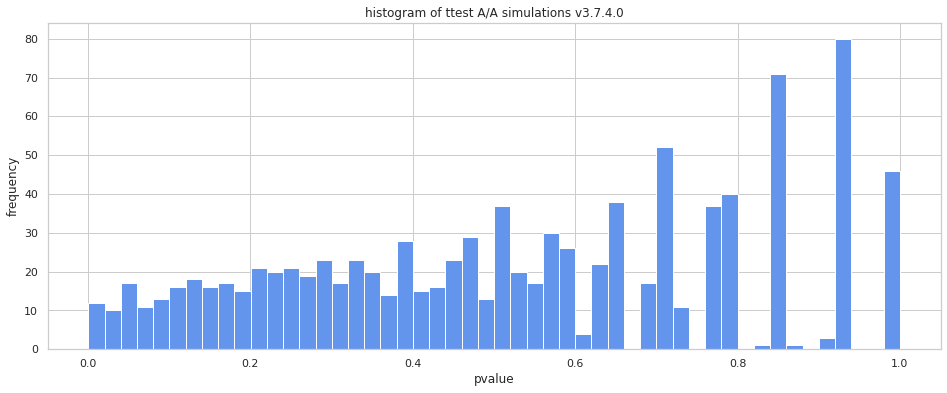

v3.7.4.0 α=0.05, FPR=0.025


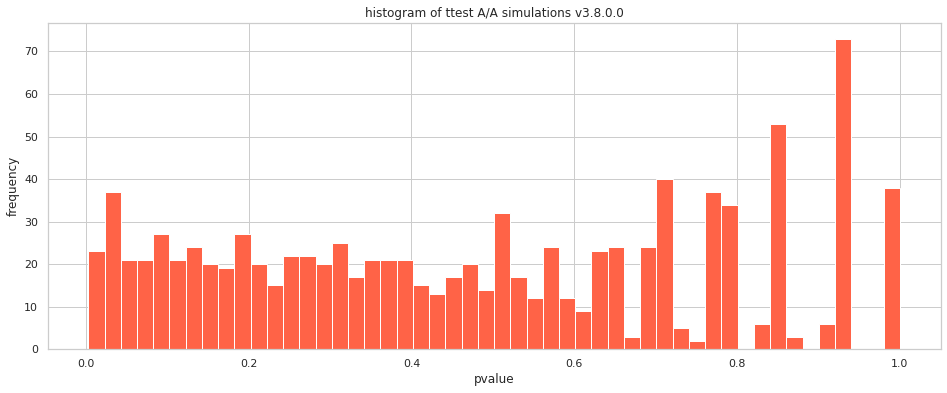

v3.8.0.0 α=0.05, FPR=0.065


In [11]:
versions = data.version.unique() # список версий

for version in versions:
    # создаём выборки
    control = data[(data.version == version) & (data.experimentVariant == 0)].purchase.values
    test = data[(data.version == version) & (data.experimentVariant == 1)].purchase.values
    # производим расчёт
    result = simulation(control, test)
    graph(result, version)

Попробуем исключить из выборки v2.8.0 где результаты некорректные, а затем провести повторный анализ оставшейся выборки.

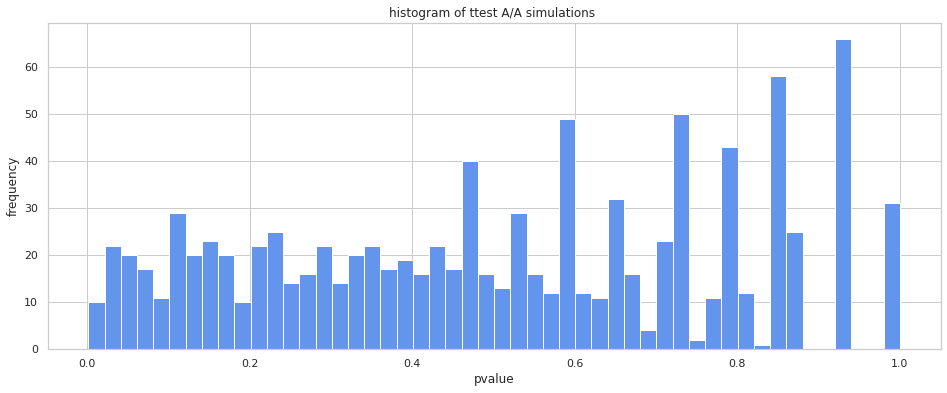

 α=0.05, FPR=0.039


In [12]:
control_cut = data[(data.version != 'v2.8.0') & (data.experimentVariant == 0)].purchase.values
test_cut = data[(data.version != 'v2.8.0') & (data.experimentVariant == 1)].purchase.values
    
result = simulation(control_cut, test_cut)
graph(result)

## Вывод 2
1. v2.8.0, и подозрительно низкий CTR в контрольной группе
2. При поверсионном сравнении control и test мы обнаружили что с некоторой регулярностью FPR>α бывает также у v3.8.0.0

